# ML project in Spark: MLlib

Spark tiene dos librerías para machine leanrning: spark.mllib y spark.ml.

__spark.mllib__ fue la primera librería en desarrollarse y fue pensada para usarse con RDDs, desde la versión de Spark 2.0 se encuentra en modo de mantenimiento.

__spark.ml__ es la librería actual de ML, cuyo funcionamiento se basa en dataframes. Se recomienda utilizar está librería sobre su predecesora.


Debido a la transción que vivimos en el cambio de librerías, usualmente utilizamos el acrónimo "MLlib" para referirnos a cualquiera de las dos librerías.

Algoritmos de aprendizaje supervisado que se encuentran disponibles en Spark:

* Linear regression
* Logistic regression
* Decision trees
* Gradient boosted trees
* Random forest
* Naive Bayes
* SVM

Algoritmo de aprendizaje no supervisado tenemos:
* k-means
* Latent Dirichlet Allocation (LDA)
* Gaussian mixture models

### Ingredientes fundamentales de un proyecto de ML

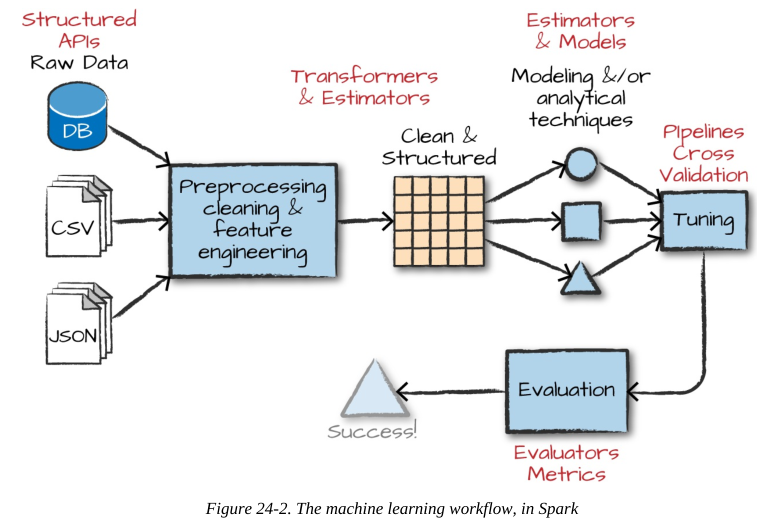


__Transformer__: Tiene como entrada un dataframe y da como salida otro dataframe. Los "transformers" no estiman parámetros, solo modifican nuestros datos de alguna forma.

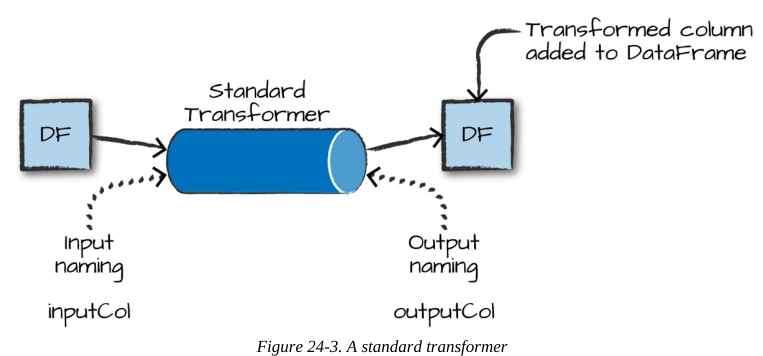

__Estimator__: Aprende o estima parámetros por medio de los datos (dataframes).

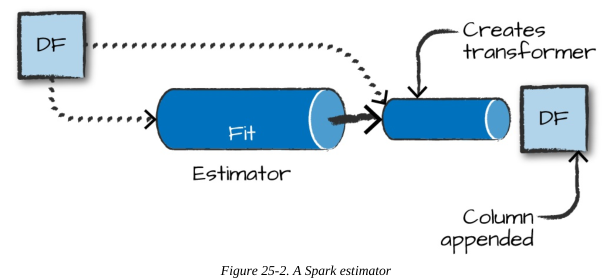

__Pipeline__: Organiza una serie de "transformers" y "estimators" en un solo modelo.

__Evaluator__: Permiten ver cúal es el desempeño de nuestro algoritmo con respecto a cierta métrica.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

spark

## Objetivo

Crear un modelo para predecir el precio por noche de la propiedades en San Francisco usando el dataset de rentas de airbnb.

## Limpieza de datos

In [ ]:
filePath = "/content/drive/MyDrive/data_sets/sf-airbnb.csv"

rawDF = spark.read.csv(filePath,
                       header="true",
                       inferSchema="true",
                       multiLine="true",
                       escape='"')

rawDF.show(3, truncate=False)

In [ ]:
rawDF.columns

__cache()__: es una instrucción que nos ayuda a cargar en "memoria distribuida" nuestro dataset (originalmente en disco).

Es recomendable realizar esta operación con datasets que se accesan frecuentemente. Sin embargo, si la memoria (distribuida) no es suficiente la operación de acceso puede ser más lenta.

"cache()" se ejecuta de forma "lazy" y se materializa cuando se manda a llamar una acción. Una forma de materializar la acción de "cache()" es utilizar la función "count()" o "show()" inmediatamente después.

Por simplicidad solo vamos a seleccionar algunas de las columnas listadas anteriormente.

In [ ]:
#--definimos una lista con todas las columnas que deseamos preservar
columnsToKeep = [
  "host_is_superhost",
  "cancellation_policy",
  "instant_bookable",
  "host_total_listings_count",
  "neighbourhood_cleansed",
  "latitude",
  "longitude",
  "property_type",
  "room_type",
  "accommodates",
  "bathrooms",
  "bedrooms",
  "beds",
  "bed_type",
  "minimum_nights",
  "number_of_reviews",
  "review_scores_rating",
  "review_scores_accuracy",
  "review_scores_cleanliness",
  "review_scores_checkin",
  "review_scores_communication",
  "review_scores_location",
  "review_scores_value",
  "price"]

#--creamos un nuevo dataframe con las columnas seleccionadas
baseDF = rawDF.select(columnsToKeep)
#--mandamos el dataset a memoria y lo materializamos con "count()"
baseDF.cache().show()

In [ ]:
baseDF.printSchema()

Observamos que la columna "price" debería ser númerica. La convertimos:

In [ ]:
import pyspark.sql.functions as F

#--usalando "translate" removemos "$," de cada registro en "price",
#-el resultado lo convertimos a doble
fixedPriceDF = (baseDF
                .withColumn("price",
                            F.translate(F.col("price"),"$,", "").cast("double")))

fixedPriceDF.show(3)

Para tener un primer vistazo de los datos podemos utilizar:
* describe()
* summary()

In [ ]:
fixedPriceDF[['host_total_listings_count']].summary(['count', 'mean', 'stddev', 'min', '25%', '50%', '75%', '90%', '95%', 'max']).show()

### Valores nulos

Algunas formas de manejar los valores nulos son:

* Eliminar las filas que contienen valores nulos
* Si son númericos: reemplazarlos con la media, mediana, etc.
* Si son categoricos: reemplazarlos con la moda o definir una nueva categoría de valores nulos.

Por ejemplo, si quisieramos eliminar las filas que contienen valores nulos en la columna "host_is_superhost":

In [ ]:
noNullsDF = fixedPriceDF.dropna(subset=["host_is_superhost"])

__dropna__: tiene tres parámetros para controlar la forma en que se eliman las filas con valores nulos:

* how: 'any' elimina la fila si cualquier elemento es nuo. 'all' elimina la fila si todos los elementos son nulos.
* thresh: valor entero, número de valores nulos mínimos para eliminar una fila o no.
* subset: lista de las columnas a considerar.

Una buena práctica es añadir un columna extra por cada columna que imputemos con la finalidad de  indicar cuales son datos originales y cuales son datos imputados.

In [ ]:
imputeCols = [
  "bedrooms",
  "bathrooms",
  "beds",
  "review_scores_rating",
  "review_scores_accuracy",
  "review_scores_cleanliness",
  "review_scores_checkin",
  "review_scores_communication",
  "review_scores_location",
  "review_scores_value"
]

#--columnas que no voy a imputar
not_imputeCols = set(noNullsDF.columns) - set(imputeCols)
not_imputeCols = list(not_imputeCols)

imputedDF = noNullsDF
imputedDF = (imputedDF
  #--seleccionar columnas sin imputar
  .select('*',
          *(F.when(F.col(c).isNull(), 1.0).otherwise(0.0).alias(c + '_na') for c in imputeCols)))

imputedDF.show(3)

Realizamos la imputación de valores

In [ ]:
from pyspark.ml.feature import Imputer

#--defino el objeto imputer
imputer = Imputer(strategy="median",
                  inputCols=imputeCols,
                  outputCols=imputeCols)

#--entreno el objeto y transformo los datos
# nota: doublesDF es el data frame que tiene las columnas de enteras a dobles
imputedDF = (imputer
            #--entrenamiento
            .fit(imputedDF)
            #--aplicando cambios
            .transform(imputedDF))

Revisamos si hay valores nulos:

In [ ]:
imputedDF\
   .select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in imputedDF.columns])\
   .show()

### Remover valores extremos

Veamos los valores mínimos y máximos de la variable respuesta "price":

In [ ]:
imputedDF.select("price").describe().show()

El mínimo es cero, ¿rentas "gratis"?. Esto no serviría de mucho a nuestro algoritmo.

Contamos cuantas rentas "gratis" existen, si son pocas las podemos eliminar sin ningún problema.

In [ ]:
imputedDF.filter(F.col("price") == 0).count()

In [ ]:
#--como es solo una fila la que contiene 0, la removemos
posPricesDF = imputedDF.filter(F.col("price") > 0)

Veamos ahora la columna "minimum_nights":

In [ ]:
posPricesDF.select("minimum_nights").describe().show()

Parece que el número de noches permitido es exageradamente grande. Exploramos más por medio de agrupar las filas por numero de noches y contar cuantos registros existe de cada uno de ellos.

In [ ]:
(posPricesDF
  .groupBy("minimum_nights").count()
  .orderBy(F.col("minimum_nights").desc())
  .show())


Pareciera que un máximo de 1 año (365 días) es una opción razonable, más allá podrían ser datos dudosos

In [ ]:
cleanDF = posPricesDF.filter(F.col("minimum_nights") <= 365)

Una vez que el dataset esta limpio, procedemos a guardarlo para empezar a modelar

In [ ]:
outputPath = "./content/drive/MyDrive/data_sets/parquet/sf-airbnb-clean/"

cleanDF.write.mode("overwrite").parquet(outputPath)

In [ ]:
spark.stop()